In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from intersection_proximity import intersection_proximity
from importlib import reload
reload(intersection_proximity)
import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [101]:
crop_rows = 1000000

In [102]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [103]:
# fill nan temporary label id's
df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# get rid of nan label id's
df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [104]:
df_interactions['timestamp'] = df_interactions['timestamp'].apply(lambda x: parse(x))

In [105]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [106]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [107]:
label_correctness.set_index(labeling_cols, inplace=True)

In [108]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [109]:
interaction_groups = df_interactions.groupby(labeling_cols)

## Calculate features

In [110]:
label_features = interaction_groups.apply(lambda x: x['zoom'].mean()).to_frame(name='zoom')

In [111]:
label_features['mousemoves'] = interaction_groups.apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove'))

In [112]:
def normalize_headings(heading_list):
    start_heading = heading_list.iloc[0]
    h = heading_list - start_heading
    h[h > 180] = h[h > 180] - 360
    return h

def range_headings(heading_list):
    norm = normalize_headings(heading_list)
    return np.max(norm) - np.min(norm)
#     return pd.Series({'heading_min': np.min(norm), 'heading_max': np.max(norm), 'heading_range': np.max(norm) - np.min(norm)})

In [113]:
label_features['heading_range'] = interaction_groups.apply(lambda x: x.groupby('gsv_panorama_id').apply(lambda y: range_headings(y['heading'])).mean())

In [114]:
def total_time(x):
    time = x['timestamp'].sort_values()
    return (time.iloc[-1] - time.iloc[0]).total_seconds()

# Time from start to finish
label_features['total_time'] = interaction_groups.apply(lambda x: total_time(x))

In [115]:
def time_between_pov_change_and_label(x):
    pov_change = x['timestamp'][x['action'] == 'POV_Changed'].max()
    last_time = x['timestamp'].max()
    return (last_time - pov_change).total_seconds()
                                
clicks_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_click') / x['gsv_panorama_id'].unique().size)


In [116]:
label_features['pov_changes_per_pano'] = interaction_groups.apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].nunique() \
                                                                  if x['gsv_panorama_id'].nunique() > 0 else 0)

In [117]:
def intersection_proximity_percentage(x):
    try:
        evt = x[x['action'] == 'LabelingCanvas_FinishLabeling'].iloc[0]
        distance, percentage = intersection_proximity.compute_proximity(evt.lat, evt.lng)
        return percentage
    except IndexError as e:
        # TODO: determine why some events have no finishlabeling event
        return -1

In [118]:
label_features['intersection_proximity'] = interaction_groups.apply(intersection_proximity_percentage)

In [119]:
label_features['correct'] = label_correctness['correct'].apply(lambda x: True if x == 't' else False if x == 'f' else np.nan)

## Make plots

In [120]:
validated_label_features = label_features[~pd.isna(label_features['correct'])]

<IPython.core.display.Javascript object>


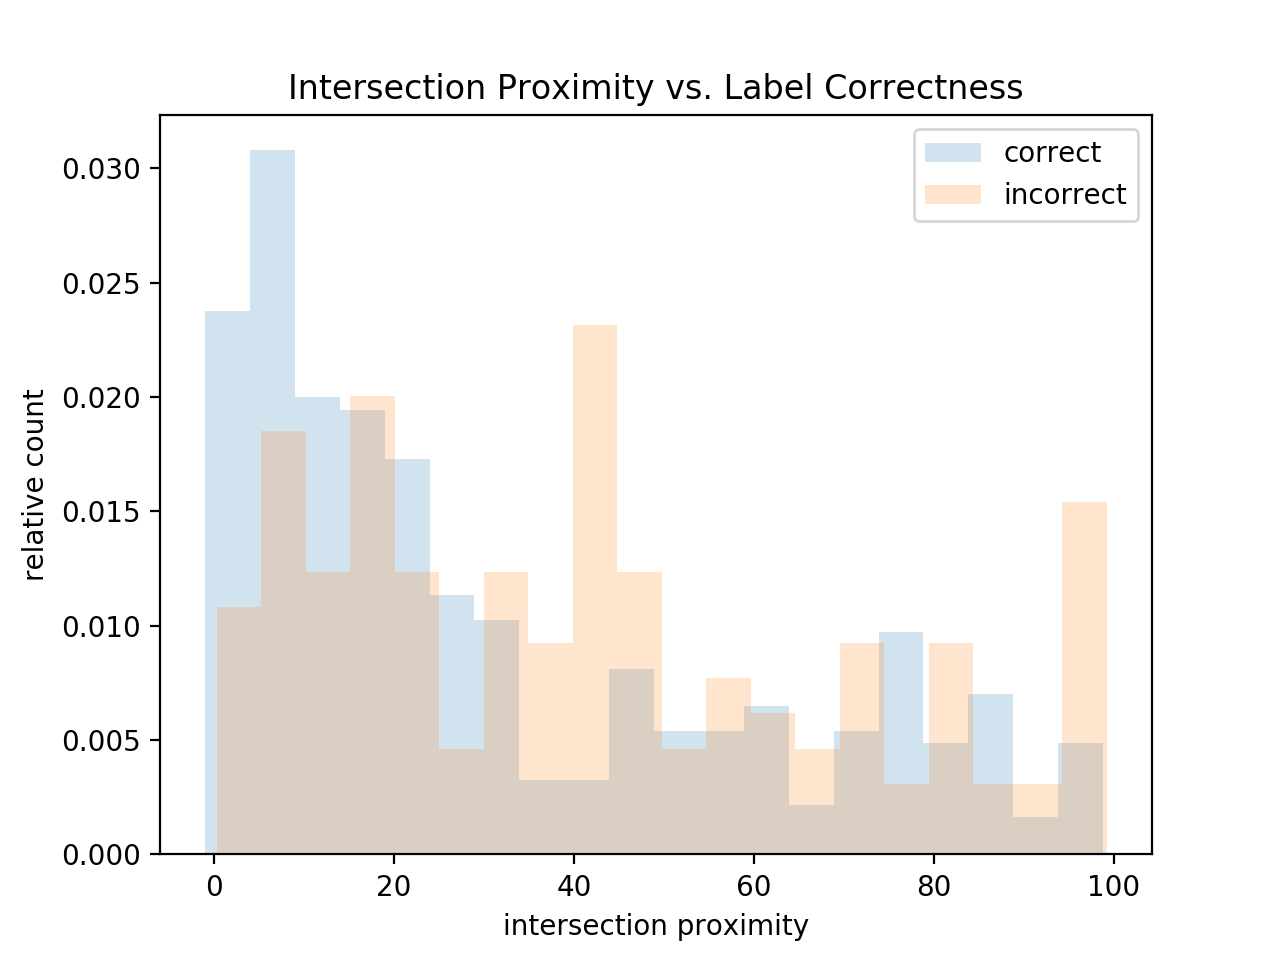

In [121]:
plt.figure()
plt.title('Intersection Proximity vs. Label Correctness')
plt.xlabel('intersection proximity')
plt.ylabel('relative count')
plt.hist(validated_label_features[validated_label_features['correct'] == True]['intersection_proximity'], density=True, alpha=0.2, bins=20, label='correct')
plt.hist(validated_label_features[validated_label_features['correct'] == False]['intersection_proximity'], density=True, alpha=0.2, bins=20, label='incorrect')
plt.legend()

## Correlation Matrix

<IPython.core.display.Javascript object>


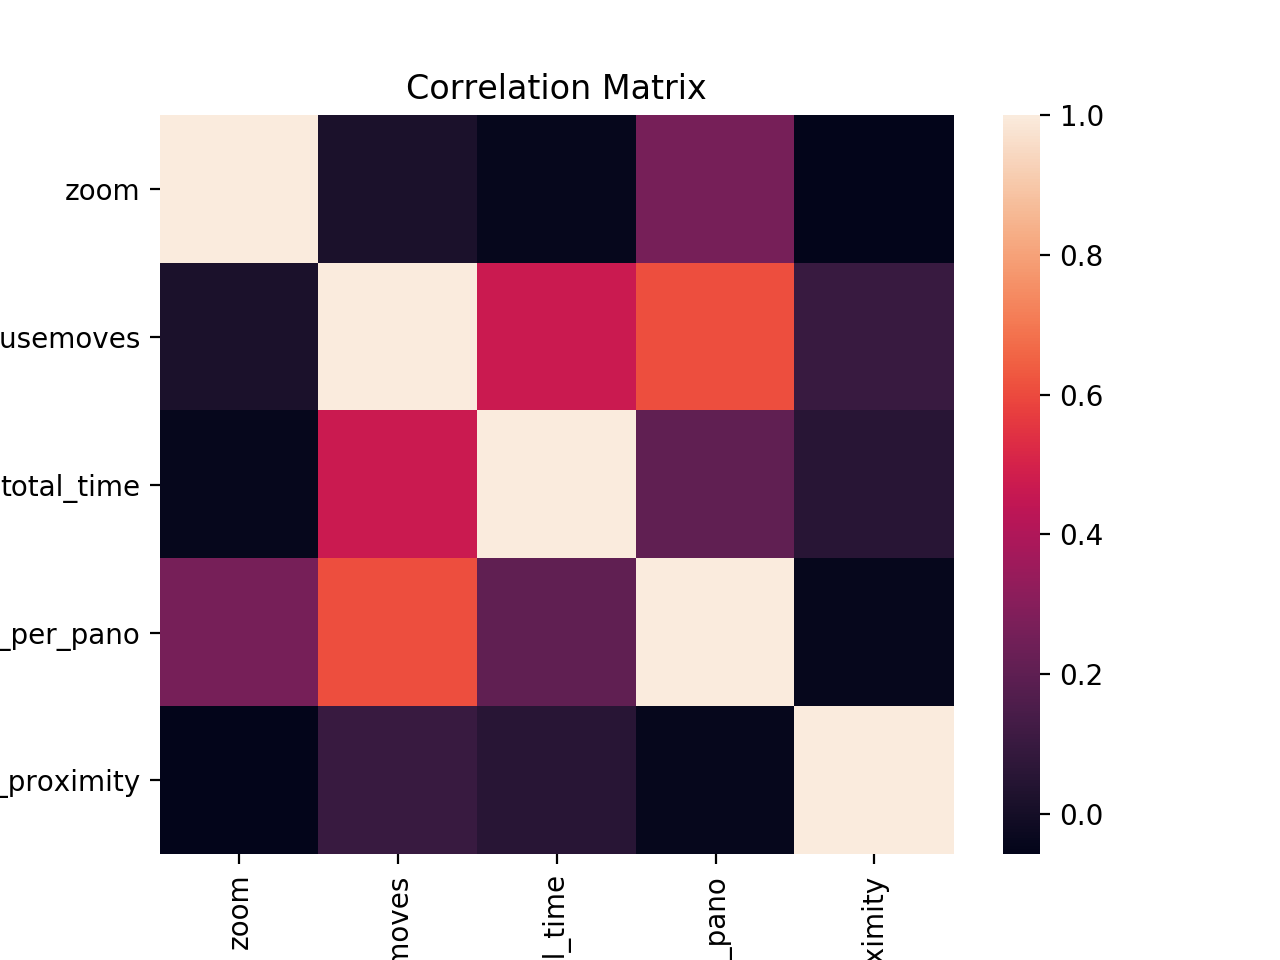

In [122]:
plt.figure()
plt.title('Correlation Matrix')
sns.heatmap(validated_label_features.corr())

<IPython.core.display.Javascript object>


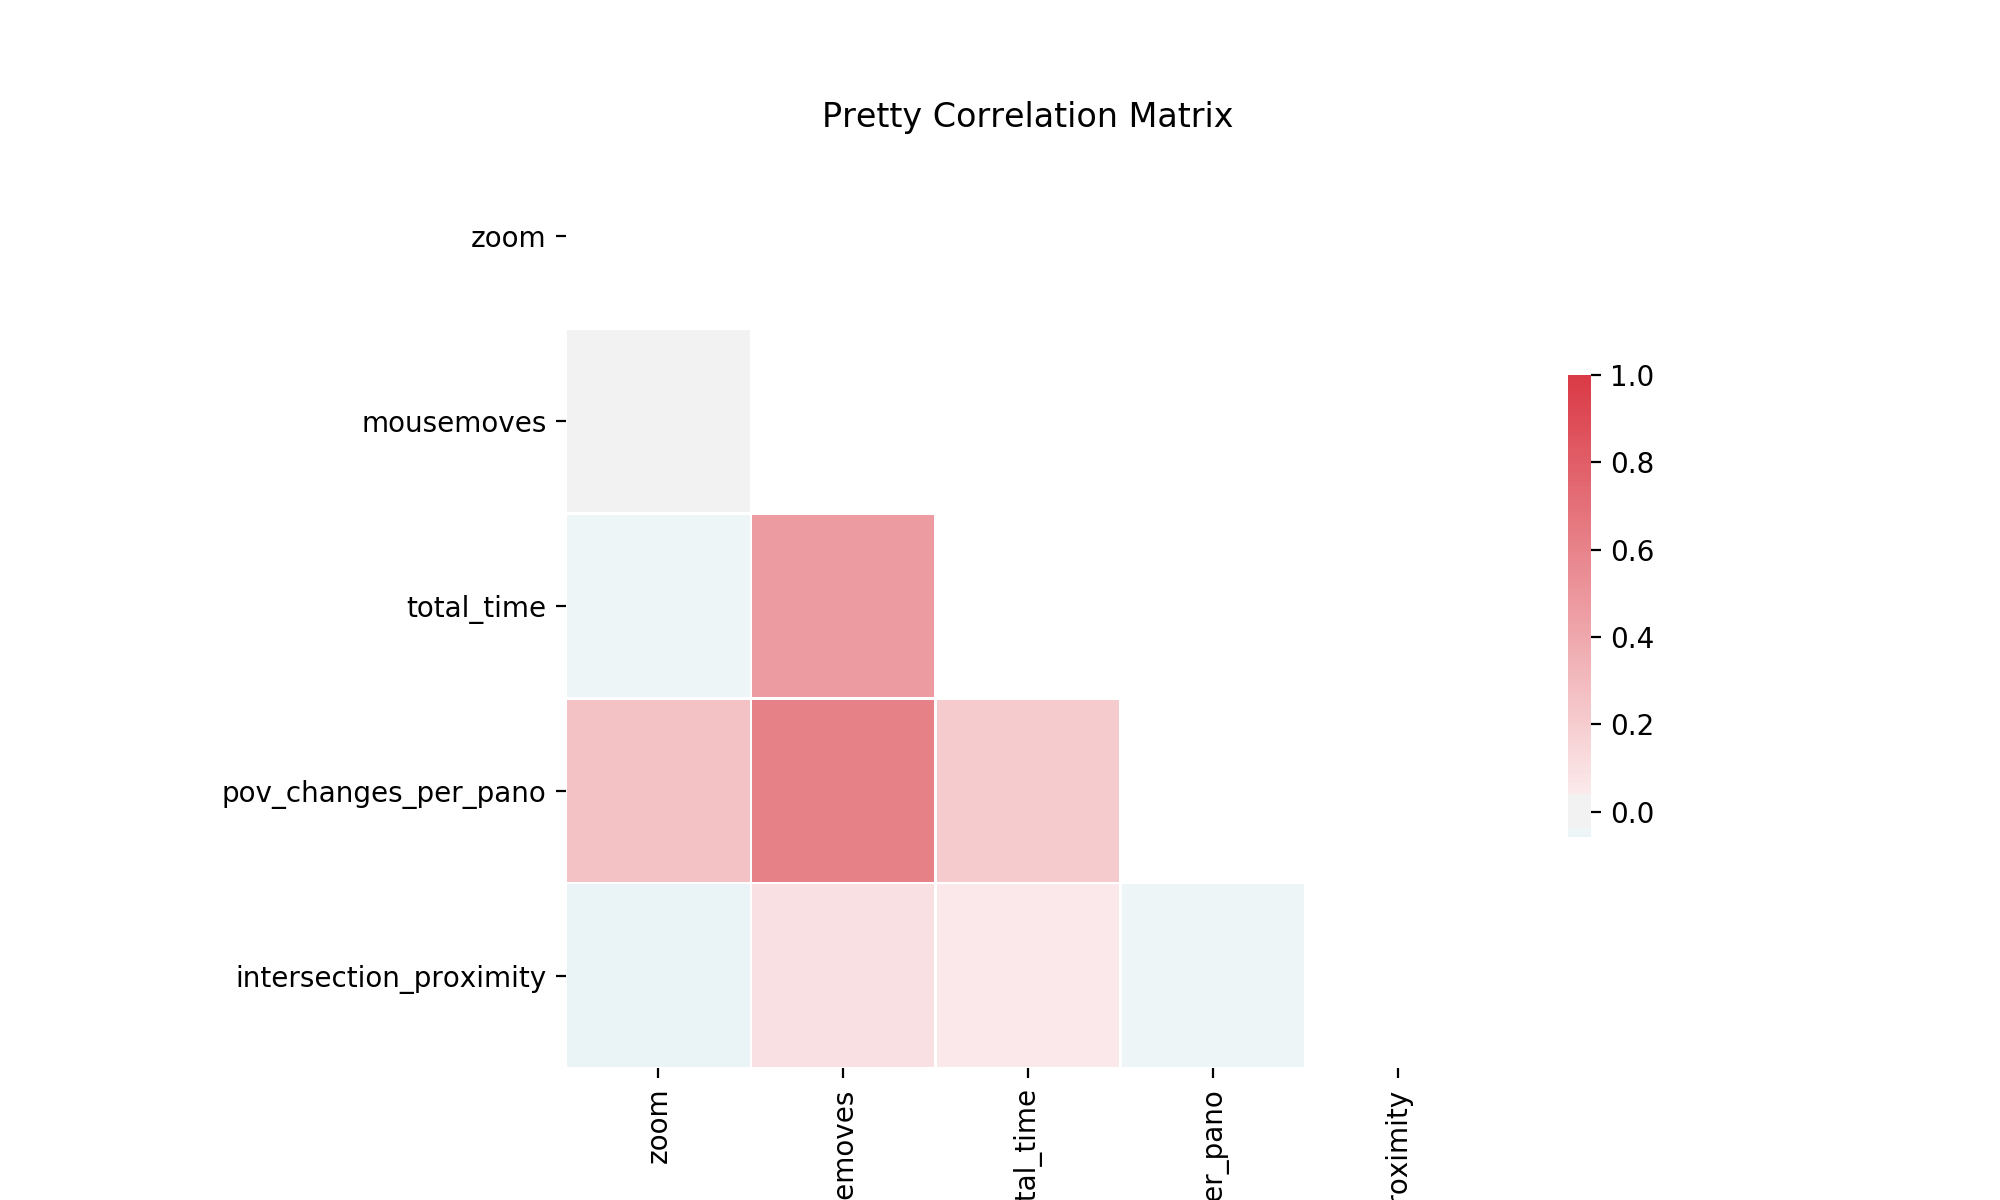

In [123]:
# Compute the correlation matrix
corr = validated_label_features.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})